# Adversarial Attack 

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
import time
import json
import pandas as pd
import copy
import seaborn as sns
from scipy.interpolate import make_interp_spline, BSpline
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import sys
from scipy.interpolate import make_interp_spline, BSpline
%run ./result_summary.ipynb
%run ./plot_functions.ipynb
sys.path.insert(0, '../src/')

output_path =  ../output/figures
plt = single_column_plt_params(plt)


In [2]:
from analyze_utilities import *
from dataset_utilities import create_cifar10_dataloaders
from distributions_metrics import *
plt = single_column_plt_params(plt)

Files already downloaded and verified
Files already downloaded and verified
['_classic_test', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10']
_internal.classic_mode: False
agg.path.chunksize: 0
animation.avconv_args: []
animation.avconv_path: avconv
animation.bitrate: -1
animation.codec: h264
animation.convert_args: []
animation.convert_path: convert
animation.embed_limit: 20.0
animation.ffmpeg_args: []
animation.ffmpeg_path: ffmpeg
animation.frame_format: png
animation.html: none
animation.html_args: []
animation.writer: ffmpeg
axes.autolimit_mode: data
axes.axisbelow: line
axes.edgecolor: black
axes.facecolor: white
axes

/Users/kobibi/anaconda3/envs/pt36/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [3]:
import seaborn as sns
adversarial_df = pd.DataFrame(columns=['regret',
                                       'erm_acc', 'nml_acc', 'genie_acc',
                                       'erm_mean_loss', 'nml_mean_loss', 'genie_mean_loss',
                                       'nml_std_loss', 'std_regret'])
fig = plt.figure(figsize=(20, 6 * len(adversarial_epsilon)))

# Get common indexes from all adeversarail experiments
_, idx_common = get_testset_intersections_from_results_dfs(
    [result_dict_to_erm_df(load_dict_from_file_list(file)) for file in files_adversarial])
adversarial_nml_df = []
eps = []
for i, (epsilon_single, file_adversarial) in enumerate(zip(adversarial_epsilon, files_adversarial)):

    # Load results dict into dataframe
    results_dict = load_dict_from_file_list(file_adversarial)
    erm_df = result_dict_to_erm_df(results_dict).loc[idx_common]
    nml_df = result_dict_to_nml_df(results_dict).loc[idx_common]
    genie_df = result_dict_to_genie_df(results_dict).loc[idx_common]

    adversarial_nml_df.append(nml_df)
    eps.append(epsilon_single)

    # Analyze statistic of single adversarial experimnet
    statistics_erm_df = calc_statistic_from_df_single(erm_df)
    statistics_nml_df = calc_statistic_from_df_single(nml_df)
    statistics_genie_df = calc_statistic_from_df_single(genie_df)

    print('epsilon = {}, num={}'.format(epsilon_single, nml_df.shape[0]))
    adversarial_df.loc[epsilon_single] = [nml_df['log10_norm_factor'].mean(),
                                          statistics_erm_df.loc['acc'][0],
                                          statistics_nml_df.loc['acc'][0],
                                          statistics_genie_df.loc['acc'][0],
                                          statistics_erm_df.loc['mean loss'][0],
                                          statistics_nml_df.loc['mean loss'][0],
                                          statistics_genie_df.loc['mean loss'][0],
                                          statistics_nml_df.loc['std loss'][0],
                                          nml_df['log10_norm_factor'].std()]
print('Adversarial dataframe: Performances\Epsilon')
adversarial_df = adversarial_df.iloc[::-1]
adversarial_df.transpose().round(2)

epsilon = 0.05, num=500
epsilon = 0.01, num=500
epsilon = 0.005, num=500
epsilon = 0.001, num=500
epsilon = 0, num=500
Adversarial dataframe: Performances\Epsilon


,0.0,0.001,0.005,0.01,0.05
regret,0.15,0.13,0.18,0.22,0.33
erm_acc,0.92,0.88,0.77,0.68,0.26
nml_acc,0.92,0.87,0.77,0.69,0.27
genie_acc,0.99,0.96,0.92,0.86,0.53
erm_mean_loss,0.19,0.31,0.70,1.11,3.22
nml_mean_loss,0.18,0.20,0.35,0.52,1.72
genie_mean_loss,0.03,0.07,0.17,0.31,1.39
nml_std_loss,0.29,0.45,0.69,0.92,1.93
std_regret,0.19,0.17,0.18,0.18,0.16


<Figure size 1440x2160 with 0 Axes>

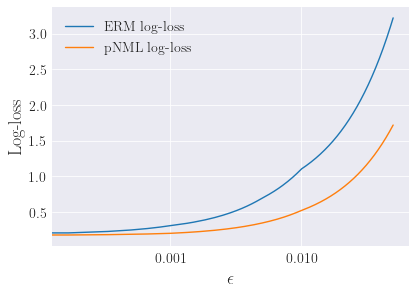

In [4]:
def smooth_graph(x, y, pow=1):

    x_smooth = np.linspace(x.min(), x.max(), 300)
    spl = make_interp_spline(x, y, k=pow)
    y_smooth = spl(x_smooth)
    return x_smooth, y_smooth


# Check noisy data
color = 'royalblue'
fig, ax1 = plt.subplots()

x, y = smooth_graph(adversarial_df.index.values,
                    adversarial_df['erm_mean_loss'])
ax1.plot(x, y, label='ERM log-loss')

x, y = smooth_graph(adversarial_df.index.values,
                    adversarial_df['nml_mean_loss'])
ax1.plot(x, y, label='pNML log-loss')

ax1.set_ylabel('Loss')
ax1.set_ylabel('Log-loss')
ax1.set_xlabel('$\epsilon$')
ax1.set_xscale('log',  basex=10)
for axis in [ax1.xaxis, ax1.yaxis]:
    formatter = ScalarFormatter()
    formatter.set_scientific(False)
    axis.set_major_formatter(formatter)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax1.legend()
plt.show()

In [5]:
# get last member in the list. it is epsilon=0
ind_df = adversarial_nml_df[-1]

# Iterate on attack strength
for (ooo_dataset, ooo_df) in zip(eps, adversarial_nml_df):
    upsample_ratio = int(ind_df.shape[0] / ooo_df.shape[0])
    print('Upsample ratio: ', upsample_ratio)

    # Regret based
    y_score_ind = (1.0 - ind_df['log10_norm_factor']).tolist() + \
                  (1.0 - ooo_df['log10_norm_factor']).tolist()
    y_true_ind = [True] * ind_df.shape[0] + [False] * ooo_df.shape[0]

    ood_df_ours = calc_performance_in_out_dist(y_true_ind, y_score_ind)
    ood_df_ours = ood_df_ours.rename(index={0: 'Regret'})

    # Summary
    merged_pd = ood_df_ours
    print('%s:' % ooo_dataset)
    print(merged_pd.round(2))
    print()

Upsample ratio:  1
0.05:
        KL Divergence  Bhattach Distance  KL in P_lamb
Regret           0.67               0.17          0.17

Upsample ratio:  1
0.01:
        KL Divergence  Bhattach Distance  KL in P_lamb
Regret           0.14               0.03          0.03

Upsample ratio:  1
0.005:
        KL Divergence  Bhattach Distance  KL in P_lamb
Regret           0.05               0.01          0.01

Upsample ratio:  1
0.001:
        KL Divergence  Bhattach Distance  KL in P_lamb
Regret           0.03               0.01          0.01

Upsample ratio:  1
0:
        KL Divergence  Bhattach Distance  KL in P_lamb
Regret            0.0               -0.0           0.0

